# Causal Data Science Week 6 Tutorial

In this tutorial we will practice how to learn a causal graph using score based structure learning with the GES algorithm. We will use the python implementation of the algorithm from the package GES. You can also choose to use the GES implementation in CDT, which is a python wrapper of an R script.

## GES algorithm

Greedy Equivalence Search (GES) (https://www.jmlr.org/papers/volume3/chickering02b/chickering02b.pdf) is a score-based causal discovery algorithm. The algorithm starts with an empty graph, progressively adds potential edges, and then removes unnecessary edges in a pattern. At each step, the decision is measured by a score such as Bayesian Information Criterion (BIC) score. The resulting model at each step is mapped to the corresponding Markov equivalence class.

The GES algorithm has two phases:
- forward step;
- backward step. 


In [3]:
# !pip install ges

     |████████████████████████████████| 47 kB 3.1 MB/s eta 0:00:011


In [1]:
# import necessary packages
import warnings
warnings.filterwarnings('ignore')

import dowhy
from dowhy import CausalModel

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from numpy.random import normal

We use the same synthetic dataset as Tutorial 5, which contains 5 variables and linear dependencies between them. For an easier demonstration of the algorithm later, we re-name the variables. The true underlying causal graph is two cells below.

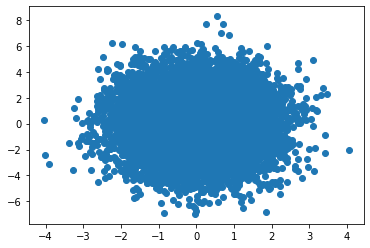

In [2]:
n_samples=10000

np.random.seed(2022)

eps1 = normal(0, 1, n_samples)
eps2 = normal(0, 2, n_samples)
eps3 = normal(0, 0.7, n_samples)
eps4 = normal(0, 1.5, n_samples)
eps5 = normal(0, 1, n_samples)

x0 = eps1
x1 = eps2
x2 = x0 + x1 + eps3
x3 = 2 * x0 + eps4
x4 = 3 * x2 + eps5

# we can plot scatter plots between any two variables 
plt.scatter(x0, x1)

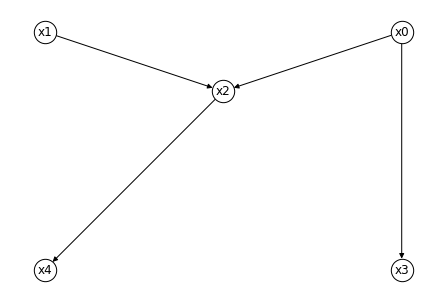

In [3]:
nodes = ["x0", "x1", "x2", "x3", "x4"]
pos = {'x1': (-1, 1),              'x0': (1, 1),
       'x2': (0, 0.5),          'x3': (1, -1), 
       'x4': (-1, -1),}

df = pd.DataFrame({'x0': x0,'x1': x1,'x2': x2,'x3': x3,'x4': x4})
df.head()

true_graph = nx.DiGraph()
true_graph.add_nodes_from(nodes)
true_graph.add_edges_from([('x0', 'x2'), ('x1', 'x2'), ('x0', 'x3'), ('x2', 'x4')])

nx.draw(true_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos)

Below, we prepare the data for GES, which requires a numpy array format.

In [4]:
import ges

data = df.to_numpy()
print(data)

[[-5.27899086e-04  1.28782841e-01  6.23842409e-01  4.15232953e-01
   1.18332586e+00]
 [-2.74901425e-01  1.46282129e+00  2.31066417e+00 -1.10149468e+00
   6.47029429e+00]
 [-1.39285562e-01  2.39096009e+00  1.34831950e+00  1.33079236e-01
   4.57545917e+00]
 ...
 [ 3.11093990e-01 -8.64769580e-01 -3.29712589e-01 -3.83444934e-01
  -3.17489328e-01]
 [ 6.99104311e-02 -2.60389299e+00 -3.49076589e+00  1.08980604e+00
  -1.05456551e+01]
 [-2.45055084e-01  1.44412299e+00  1.16498160e+00 -2.27416937e+00
   4.51736564e+00]]


We check the final learned graph from calling ```fit_bic()```. GES contains forward phase and backward phase. It can be improved by including a "turning phase" (https://www.jmlr.org/papers/volume13/hauser12a/hauser12a.pdf), which is implemented in the GES package too. In this tutorial, we do not cover the turning phase (you can try exploring it yourself). 

The debug parameter controls the printing of the intermediate results. Changing debug to a different level (<5) will show different levels of output for debugging (0 for no output and 4 for the most specific outputs). 

In [5]:
def get_colors(G):
    edges = G.edges()
    for (x, y) in G.edges():
        if (y, x) in edges:
            # bi-directional edge
            nx.set_edge_attributes(G, {(x, y): {"directed": False}})
        else:
            nx.set_edge_attributes(G, {(x, y): {"directed": True}})
    colors = ['black' if G[u][v]['directed']==True else 'r' for u,v in G.edges()]
    return colors

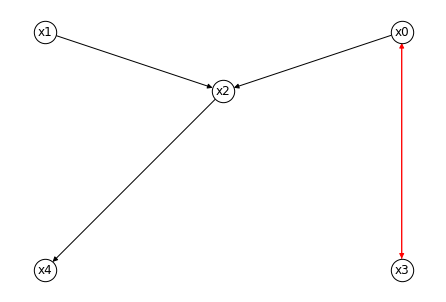

In [6]:
estimate, score = ges.fit_bic(data, phases=['forward', 'backward'], debug=0) # debug = 0-4 for intermediate results
H = nx.DiGraph()
H = nx.from_numpy_array(estimate, create_using=nx.DiGraph)
mapping = dict(zip(H.nodes, nodes))
H = nx.relabel_nodes(H, mapping)
colors = get_colors(H)
nx.draw(H, with_labels=True, node_size=500, node_color='w', 
        edgecolors ='black', pos=pos, edge_color=colors)

Now, we look at the learning process step-by-step. 
We first initalize a Gaussian BIC score object. This object will pre-compute and cache l0-penalized gaussian likelihood scores. By default, we use the 'scatter' method and the empirical covariance matrix to compute the likelihood.

In [7]:
from ges.scores.gauss_obs_l0_pen import GaussObsL0Pen
# initalize the Gaussian BIC score
cache = GaussObsL0Pen(data)
print(cache._scatter)

[[ 9.90781856e-01  9.80207368e-04  9.90358505e-01  1.95521060e+00
   2.96214912e+00]
 [ 9.80207368e-04  4.05715808e+00  4.04194358e+00 -1.50336848e-02
   1.21190014e+01]
 [ 9.90358505e-01  4.04194358e+00  5.50153053e+00  1.92819036e+00
   1.64898587e+01]
 [ 1.95521060e+00 -1.50336848e-02  1.92819036e+00  6.09701974e+00
   5.75794521e+00]
 [ 2.96214912e+00  1.21190014e+01  1.64898587e+01  5.75794521e+00
   5.04505860e+01]]


Following this, we run the learning process that includes the forward phase and backward phase. In the forward phase, an edge is added at each step, while edges are removed for the backward phase.

The graph is stored in an adjacency matrix A where ```A[i][j] = 1``` indicates the existence of a directed edge going from i to j, and ```A[i][j] = 0``` otherwise.

Because we are searching the Markov Equivalence Class, every step we will validate if the operation meets two conditons (see paper) and therefore is a valid operation.

In [8]:
# define parameters
phases = ['forward', 'backward']
debug = 3 # with 3 we can see the results 
iterate = False
score_class = cache

In [9]:
# The code below is taken directly from the GES library
from ges import forward_step, backward_step, turning_step
import ges.utils as utils

# Unless indicated otherwise, initialize to the empty graph
A0 = np.zeros((cache.p, cache.p))
# initialize the score and adjacency matrix
A, score_change = A0, np.Inf

# Set the completion algorithm
completion_algorithm = utils.pdag_to_cpdag
# GES procedure
total_score = 0

inter_adjs = []
inter_scores = []
# Run each phase
while True:
    last_total_score = total_score
    for phase in phases:
        if phase == 'forward':
            fun = forward_step
        elif phase == 'backward':
            fun = backward_step
        elif phase == 'turning':
            fun = turning_step
        else:
            raise ValueError('Invalid phase "%s" specified' % phase)
        print("\nGES %s phase start" % phase) if debug else None
        print("-------------------------") if debug else None
        while True:
            score_change, new_A = fun(A, score_class, max(0, debug - 1))
            if score_change > 0:
                A = completion_algorithm(new_A)
                inter_adjs.append(A)
                total_score += score_change
                inter_scores.append(total_score)
            else:
                break
        print("-----------------------") if debug else None
        print("GES %s phase end" % phase) if debug else None
        print("Total score: %0.4f" % total_score) if debug else None
        [print(row) for row in A] if debug else None
    if total_score <= last_total_score or not iterate:
        break


GES forward phase start
-------------------------
  20 candidate edges
    insert(0,1,[]) -> -4.6039750811414706
    insert(0,2,[]) -> 987.2725238463699498
    insert(0,3,[]) -> 5005.1334009327219974
    insert(0,4,[]) -> 960.5121131798005081
    insert(1,0,[]) -> -4.6039750811423801
    insert(1,2,[]) -> 6578.1030353265787198
    insert(1,3,[]) -> -4.5594862682046369
    insert(1,4,[]) -> 6316.4692165751293942
    insert(2,0,[]) -> 987.2725238463699498
    insert(2,1,[]) -> 6578.1030353265787198
    insert(2,3,[]) -> 582.7883504783785611
    insert(2,4,[]) -> 19476.0789899168994452
    insert(3,0,[]) -> 5005.1334009327201784
    insert(3,1,[]) -> -4.5594862682082749
    insert(3,2,[]) -> 582.7883504783785611
    insert(3,4,[]) -> 565.6256945400673430
    insert(4,0,[]) -> 960.5121131798041461
    insert(4,1,[]) -> 6316.4692165751330322
    insert(4,2,[]) -> 19476.0789899169176351
    insert(4,3,[]) -> 565.6256945400746190
  Best operator: insert(4, 2, []) -> (19476.0790)
  18 candida

From the output, we can see that at each step in each phase, a set of candidate edges that we can insert/delete is considered, and the score change of the insertion or deletion is calculated. 

Considering all edge candidates and a set of potential variables that might form a v-structure (all possible subsets of neighbors of y which are NOT adjacent to x), the algorithm chooses the best operation for the highest score gain. 

We keep inserting/deleting edges until no action will result in a positive score gain.

We can also visualize the whole process and each step by drawing the current graph. We can see how the graph changes while we are adding more edges and how the addition of certain edges orients other edges.

In [10]:
def draw_from_adj(Adj):
    print(Adj)
    H = nx.MultiGraph()
    H = nx.from_numpy_array(Adj, create_using=nx.DiGraph)
    mapping = dict(zip(H.nodes, nodes))
    H = nx.relabel_nodes(H, mapping)
    colors = get_colors(H)
    nx.draw(H, with_labels=True, node_size=500, node_color='w', 
            edgecolors ='black', pos=pos, edge_color=colors)
    return H

Total_score:  0
--------Step: 1--------
Total_score:  19476.078989916918
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 1 0 0]]


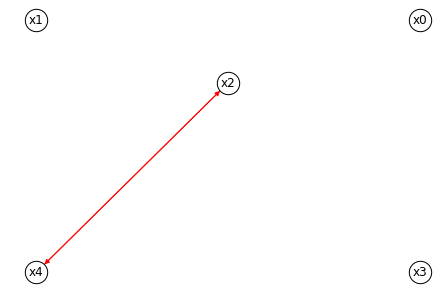

--------Step: 2--------
Total_score:  26054.182025243495
[[0 0 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 1]
 [0 0 0 0 0]
 [0 0 1 0 0]]


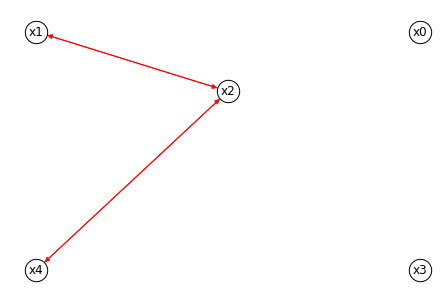

--------Step: 3--------
Total_score:  31591.919718335826
[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]]


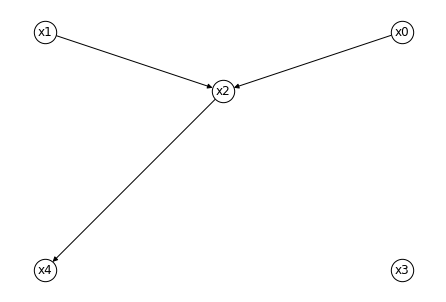

--------Step: 4--------
Total_score:  36597.053119268545
[[0 0 1 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 0 0]]


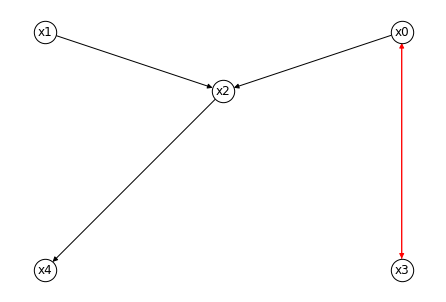

In [11]:
import matplotlib.pyplot as plt
i = 1
print("Total_score: ", 0)
for key, adj in enumerate(inter_adjs):
    fig = plt.figure(i)   
    print("--------Step: {}--------".format(i))
    print("Total_score: ", inter_scores[key])
    _ = draw_from_adj(adj)
    display(fig)
    i += 1
    plt.close()

Here we use GES package for a clearer demonstration. This package contains only a gaussian score calculating method. If your data is (partly) categorical, we suggest using the CDT package. You can use GES algorithm for exclusively categorical data, or Bayesion Network learn (BNlearn) when your data is mixed (continuous and categorical variables).

The GES implementation in DoWhy is wrapper for the GES package, which you can call as follows. Note that we need a DAG for DoWhy to do further estimation.

In [12]:
# You might need to install this package for proper graph display
# !pip install graphviz 

In [13]:
from dowhy.graph_learners.ges import GES

learner = GES(df, 'ges')
_ = learner.learn_graph()
adj = learner._adjacency_matrix
G = draw_from_adj(adj)

ModuleNotFoundError: No module named 'graphviz'